## MLEM Reconstruction Example

An example of MLEM reconstruction based on tutorial:
https://www.youtube.com/watch?v=IhETD4nSJec

Introduced Auto-Stop

In [1]:
import odl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# Create ODL data structures
space = odl.uniform_discr([-20, -20], [20, 20], [256, 256],
                          dtype='float32')
geometry = odl.tomo.parallel_beam_geometry(space)
ray_transform = odl.tomo.RayTransform(space, geometry)
fbp = odl.tomo.fbp_op(ray_transform, filter_type='Hann', frequency_scaling=0.8)
grad = odl.Gradient(space)

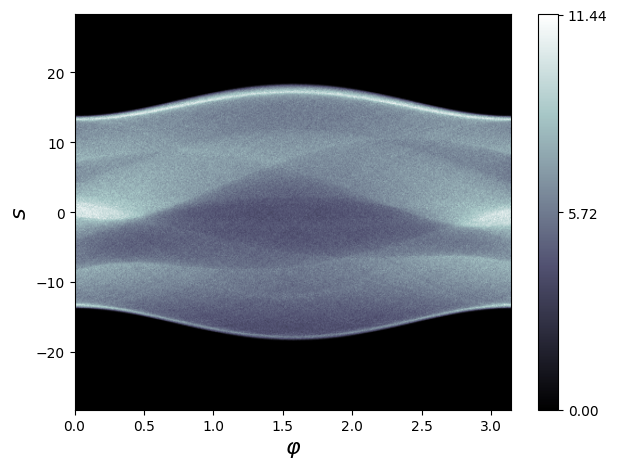

<Figure size 640x480 with 0 Axes>

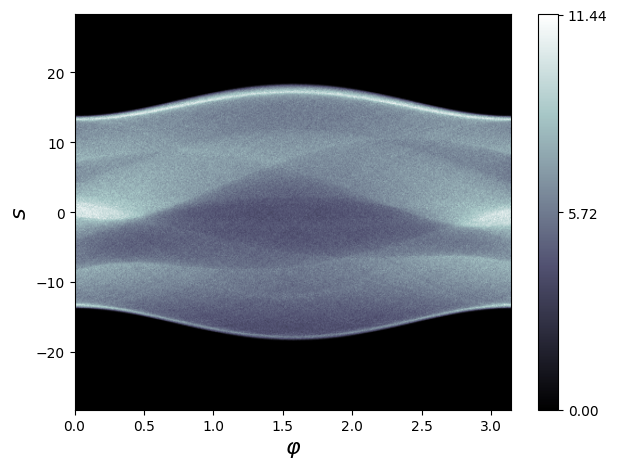

In [3]:
# Create data
phantom = odl.phantom.shepp_logan(space, True)
data = ray_transform(phantom)

# Add poison noise
noisy_data = odl.phantom.noise.poisson_noise(data*50)/50

# noisy_data = data + odl.phantom.white_noise(data.space)
# noisy_data = data

# Normalize data, as negative numbers will break this method
noisy_data = noisy_data - np.min(noisy_data)

noisy_data.show()

In [4]:
mlem_rec = space.element(np.ones([256,256]))
sino_ones = np.ones(noisy_data.shape)
sens_image = ray_transform.adjoint(sino_ones)

In [5]:
coeff = 0.02

# Here is the loss fuction from TV regularization
# The loss function consists of two parts, difference and gradient
# Gradient is used as a penalty to preserve details
# coeff is a hyper-parameter that can be manually defined

# During MLEM iterations the difference part decreases first and then increase
# And Gradient always increases

def loss(x,y):
    l = (np.sum((ray_transform(x) - y) ** 2) +
        coeff * np.sum(np.abs(grad(x))))
    return l

1155.81 478.6584765625
151


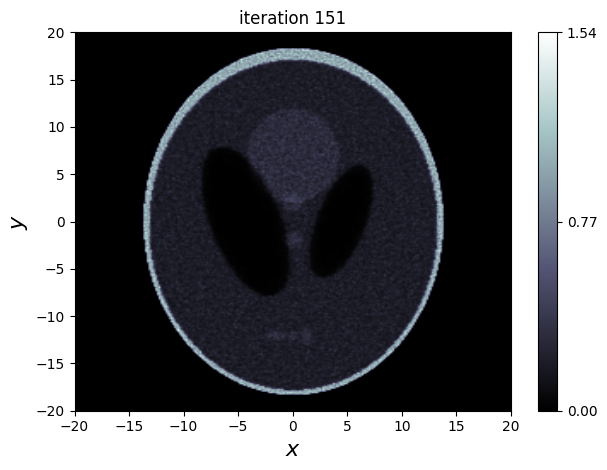

<Figure size 640x480 with 0 Axes>

In [6]:
difference_last = 2*np.sum((ray_transform(mlem_rec) - data) ** 2)

for i in range(500):
    r = ray_transform(mlem_rec)
    difference = np.sum((ray_transform(mlem_rec) - data) ** 2)
    gradient = np.sum(np.abs(grad(mlem_rec)))

    print(difference, coeff * gradient)
    # So currently there's two ideas about auto-stopping
    # Either stop when the difference no longer decreasing
    if difference_last - difference < difference / 10000:

    # Or stop when the gradient is larger than difference to preserve details
    # But difference and coeff*gradient may never meet each other
    # if difference < coeff * gradient :
        
        print(i+1)
        mlem_rec.show(title=('iteration ' + str(i+1)))
        break
    
    ratio = noisy_data / (r+0.0000000000001)
    correction = ray_transform.adjoint(ratio) / sens_image
    mlem_rec = mlem_rec * correction
    mlem_rec.show(title=('iteration ' + str(i+1)))
    clear_output(wait=True)

    difference_last = difference

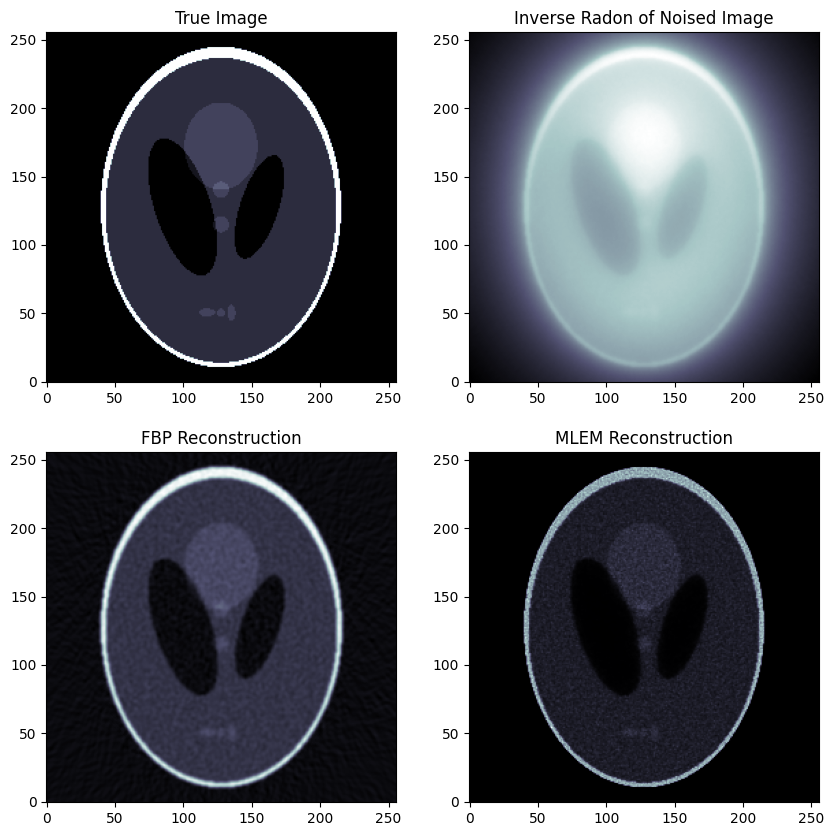

In [7]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
ax[0,0].imshow(np.transpose(phantom.data), cmap='bone', origin='lower')
ax[0,0].set_title("True Image")
ax[0,1].imshow(np.transpose(ray_transform.adjoint(noisy_data).data), cmap='bone', origin='lower')
ax[0,1].set_title("Inverse Radon of Noised Image")
ax[1,0].imshow(np.transpose(fbp(noisy_data).data), cmap='bone', origin='lower')
ax[1,0].set_title("FBP Reconstruction")
ax[1,1].imshow(np.transpose(mlem_rec.data), cmap='bone', origin='lower')
ax[1,1].set_title("MLEM Reconstruction")
plt.show()
